# Comparing axis-aligned decision tree versus oblique decision tree on sklearn digits dataset
Here we extend our analysis beyound our previous `Iris` and `simulation` datasets to measure performance of oblique forest against random forset on sklearn digits dataset. We assessed performance of each algorithm using one verus rest ROC-AUC score followed by multi-class confusion matrix. As seen from previous notebooks, OF outperforms RF in this real-world setting as well.

### Environment
- Python 3.8.13
- [Sklearn-Adam's dev branch](https://github.com/neurodata/scikit-learn/tree/obliquepr)

In [1]:
!python --version

Python 3.8.13


### Import packages

In [2]:
import sklearn
from sklearn.ensemble import RandomForestClassifier, ObliqueRandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
from sklearn.model_selection import RepeatedKFold, cross_validate

from collections import Counter
from datetime import datetime
from tqdm import tqdm
import itertools
import os
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

random_state = 123456
np.random.seed(random_state)
CLABEL = ['RF', 'OF']

sklearn.__version__

'1.2.dev0'

In [3]:
today = str(datetime.now().date())
today

'2022-06-16'

#### Load `digits` dataset from sklearn dataset module
The sklearn digits dataset consists of 8x8 arrays of grayscale values of hand-written digits. More information is available in this [document](https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html)

In [4]:
data = load_digits()
data.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [5]:
data.data.shape, data.target.shape

((1797, 64), (1797,))

In [6]:
X = data.data
y = data.target

Text(0.5, 1.0, '0')

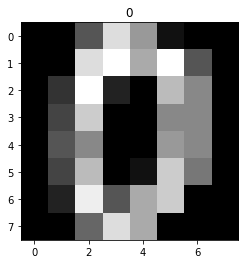

In [7]:
plt.imshow(X[0,:].reshape(8,8), cmap='gray')
plt.title(y[0])

### train-test-split digits dataset
For this cross-validation accuracy measure, we are only using 1/10 of the digits data to limit the size of training data

In [8]:
XX, _, yy, _ = train_test_split(X, y, test_size=0.9, random_state=random_state)
Counter(y), Counter(yy)

(Counter({0: 178,
          1: 182,
          2: 177,
          3: 183,
          4: 181,
          5: 182,
          6: 181,
          7: 179,
          8: 174,
          9: 180}),
 Counter({8: 16,
          7: 16,
          1: 15,
          9: 15,
          2: 12,
          0: 27,
          6: 17,
          3: 22,
          5: 24,
          4: 15}))

In [9]:
clf = RandomForestClassifier(max_features=None, random_state=random_state)
cross_val_score(clf, X=XX, y=yy, cv=10, scoring='accuracy').mean()

0.8428104575163398

In [10]:
clf = ObliqueRandomForestClassifier(max_features=None, random_state=random_state)
cross_val_score(clf, X=XX, y=yy, cv=10, scoring='accuracy').mean()

0.9316993464052287

### Accuracy measure w.r.t. `max_features`
In addition to the mean accuracy over 10 CVs, we assessed the difference (OF-RF) over 10 CVs using different values for `max_features`

In [11]:
def run_experiment(X, y, cv=10):
    max_features = ['sqrt', X.shape[1]]

    output = []

    for mf in max_features:
        tmp = [f'{mf}']

        clfs = [
            RandomForestClassifier(max_features=mf, random_state=random_state),
            ObliqueRandomForestClassifier(max_features=mf, random_state=random_state)
        ]

        for clf in clfs:
            cv_score = cross_val_score(clf, X=X, y=y, cv=cv, scoring='accuracy')
            tmp.append(cv_score)
        
        output.append(tmp)

    df_out = pd.DataFrame(output, columns=['max_features', 'RF', 'OF']).explode(['RF','OF'])
    df_out['delta'] = df_out.apply(lambda x: x.OF-x.RF, axis=1)

    # print('Run Complete')

    return df_out

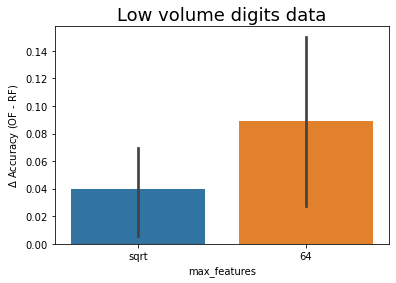

In [12]:
df_out = run_experiment(X=XX, y=yy)

fig, ax = plt.subplots()
sns.barplot(data=df_out, x='max_features', y='delta', ax=ax)
ax.set_ylabel(r'$\Delta$ Accuracy (OF - RF)')
ax.set_title('Low volume digits data', fontsize=18);

#### OvR multi-class ROC curves for the sklearn digits dataset
One versus rest ROC-AUC assessment for multi-class setting. The code to compute and draw ROC-AUC curves are mostly adapted from sklearn [documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)

In [13]:
def compute_ROC_AUC(y_test_10, y_score):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_10[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_10.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    return roc_auc, fpr, tpr

In [14]:
def draw_ROC(name, roc_auc, tpr, fpr):
    lw = 2 #line width
    tab10 = plt.get_cmap('tab10', 10) #color iterable

    # Plot all ROC curves
    plt.figure(figsize=(10,7))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = tab10(np.linspace(0, 1, 10))
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
            alpha=0.4
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=15)
    plt.ylabel("True Positive Rate", fontsize=15)
    plt.title(f"Multiclass ROC curve for {name}", fontsize=15)
    plt.legend(loc="lower right")
    plt.show()
    # return plt.figure

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.98, random_state=random_state)
n_classes = len(set(y_test))
print(f'There are {n_classes} classes')
Counter(y_train), Counter(y_test)

There are 10 classes


(Counter({8: 1, 4: 5, 0: 5, 6: 4, 1: 4, 7: 6, 5: 4, 2: 2, 3: 2, 9: 2}),
 Counter({8: 173,
          3: 181,
          2: 175,
          1: 178,
          5: 178,
          9: 178,
          6: 177,
          7: 173,
          4: 176,
          0: 173}))

In [16]:
clfs = [
    RandomForestClassifier(max_features=None, random_state=random_state),
    ObliqueRandomForestClassifier(max_features=None, random_state=random_state)
]

In [17]:
# Random Forest Parameters
clfs[0].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123456,
 'verbose': 0,
 'warm_start': False}

In [18]:
# Oblique Forest Parameters
clfs[1].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'feature_combinations': 1.5,
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123456,
 'verbose': 0,
 'warm_start': False}

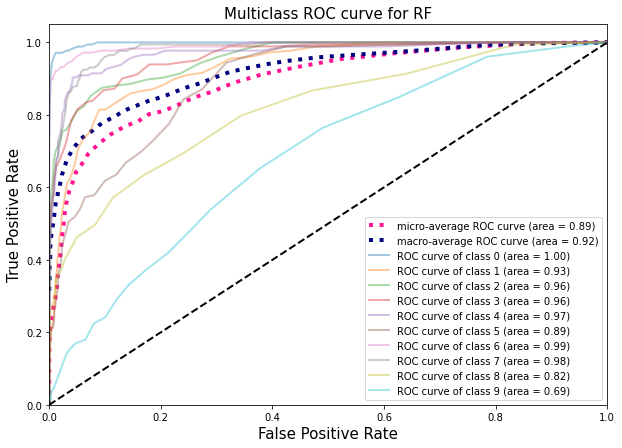

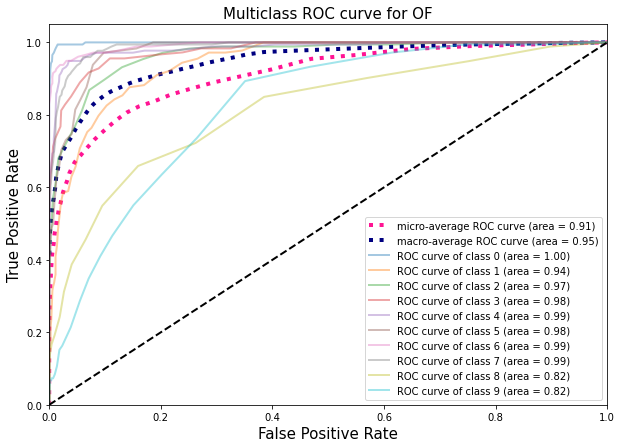

In [19]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_10 = label_binarize(y_test, classes=range(n_classes))
confusion_matrix = []

for name, clf in zip(['RF', 'OF'], clfs):
    # clf_ovr = OneVsRestClassifier(estimator=clf)
    # y_score = clf_ovr.fit(X_train, y_train).predict_proba(X_test)
    y_score = clf.fit(X_train, y_train).predict_proba(X_test)

    confusion_matrix.append(
        [name, np.argmax(y_test_10, axis=1), np.argmax(y_score, axis=1)]
    )

    roc_auc, fpr, tpr = compute_ROC_AUC(y_test_10, y_score)
    fig = draw_ROC(name, roc_auc, tpr, fpr)

#### Confusion Matrix for RF and OF

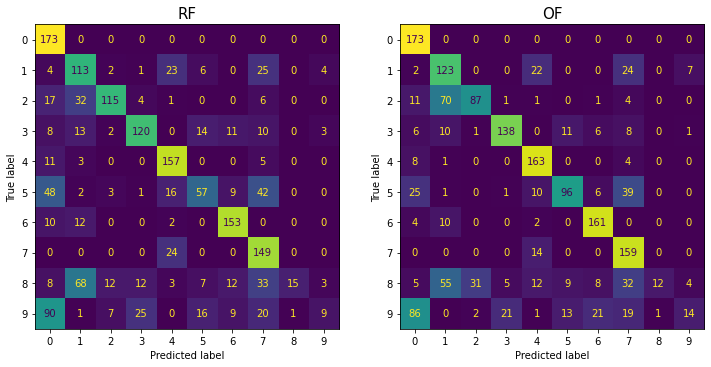

In [20]:
from sklearn import metrics

fig, ax = plt.subplots(1,2,figsize=(12,6))

for i, cm in enumerate(confusion_matrix):
    metrics.ConfusionMatrixDisplay.from_predictions(y_true=cm[1],y_pred=cm[2], colorbar=False, ax=ax[i])
    ax[i].set_title(cm[0], fontsize=15)

### Robustedness test using batched digits dataset
Following experiment tests for robustness of each model using batched digits dataset. The test employs the custom batch generator that splits data into given number of batches and each batch size. The corresponding confusion matrices are generated for each model for each batch 

In [21]:
import random

def batch_generator(size, batch_size, X, y, random_state):
    start = 0
    N = len(X)

    max_size = size*(batch_size+1)
    cnt = 0

    random.seed(random_state)
    idx = random.sample(range(N),N)
    X, y = X[idx], y[idx]

    if max_size > N:
        raise IndexError('Index Out of Range')

    for end in range(size,max_size,size):
        outer_idx = [i for i in range(N) if i < start or i > end]
        yield X[start:end], y[start:end], X[outer_idx], y[outer_idx]
        start = end
        cnt += 1
        print(f'Batch #{cnt}')

In [22]:
output = []
confusion_matrix_batch = []

for i, (train_mX, train_my, test_mX, test_my) in enumerate(batch_generator(50, 5, X, y, random_state=random_state)):

    # print(train_mX.shape, test_mX.shape)
    # print(Counter(train_my))

    clfs = [
        RandomForestClassifier(max_features=None, random_state=random_state),
        ObliqueRandomForestClassifier(max_features=None, random_state=random_state)
    ]

    for clf, clf_label in zip(clfs, ['Random Forest', 'Oblique Forest']):
        
        y_pred = clf.fit(train_mX,train_my).predict_proba(test_mX)
        y_test_10 = label_binarize(test_my, classes=range(n_classes))

        roc_auc, fpr, tpr = compute_ROC_AUC(y_test_10, y_pred)
        output.append([roc_auc, tpr, fpr])

        confusion_matrix_batch.append(
            [i, clf_label, np.argmax(y_test_10, axis=1), np.argmax(y_pred, axis=1), roc_auc]
        )

Batch #1
Batch #2
Batch #3
Batch #4
Batch #5


### Visualization of the batched confusion matrice
Even with very small data regime, each model was able to perform well on classifying each class. In particular, the oblique forest outperformed across all batches.

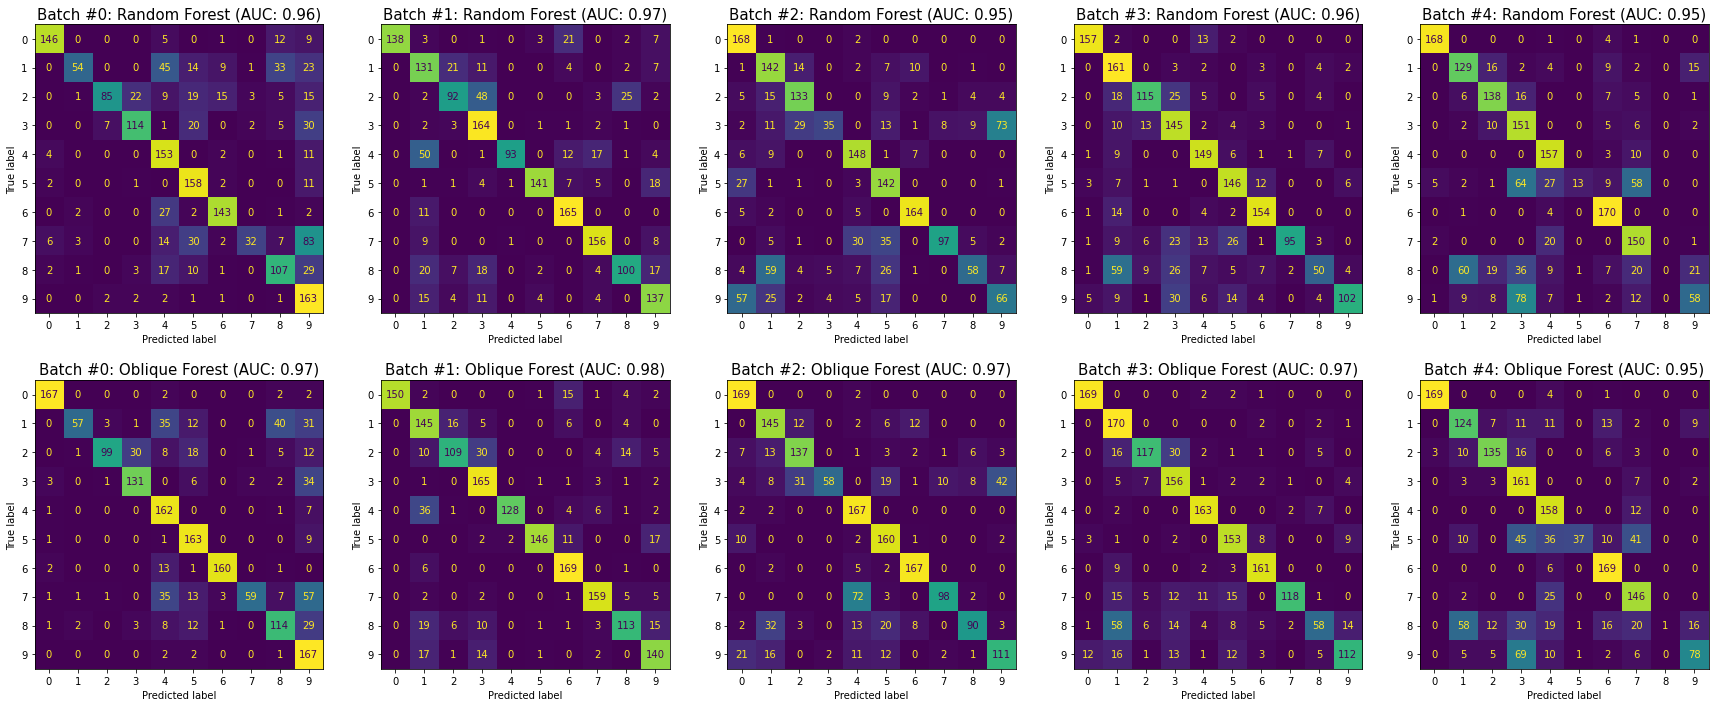

In [23]:
df_confusion = pd.DataFrame(confusion_matrix_batch).sort_values([1,0], ascending=False).to_numpy()

N = int(df_confusion.shape[0] / 2)

fig, ax = plt.subplots(2,N,figsize=(6*N,12))

for i, cm in enumerate(df_confusion):
    col = int(i%N)
    row = int(i//N)

    metrics.ConfusionMatrixDisplay.from_predictions(y_true=cm[2],y_pred=cm[3], colorbar=False, ax=ax[row,col])
    ax[row,col].set_title(f'Batch #{col}: {cm[1]} (AUC: {round(cm[4]["macro"],2)})', fontsize=15)

In [24]:
# df_batch = pd.DataFrame()

# for i, (train_mX, train_my, test_mX, test_my) in enumerate(batch_generator(150, 5, X, y, random_state=random_state)):
#     df_batch = pd.concat([df_batch, run_experiment(X=train_mX, y=train_my)])